# Baseline Model

## Importing the necessary modules

In [156]:
import pandas as pd
import numpy as np
import yfinance as yf
from ta import add_all_ta_features
from ta.utils import dropna
from tensorflow.keras.models import Sequential
from keras.layers import LSTM,Dense
import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

## Fetching the stock price data

In [12]:
def fetch_dow_jones_data(stock_name='^DJI',start_date='2018-01-01', end_date='2022-12-31'):
    """
    Fetches Dow Jones Index opening and closing price day wise for the given start and end dates.

    Args:
        stock_name (str): Name of the stock to be fetched
        start_date (str): The start date in YYYY-MM-DD format.
        end_date (str): The end date in YYYY-MM-DD format.

    Returns:
        pd.DataFrame: A DataFrame containing the Dow Jones Index opening and closing price for the given start and end dates.
    """

    df = yf.download(stock_name, start=start_date, end=end_date)
    df['Open'] = df['Open'].astype(float)
    df['Close'] = df['Close'].astype(float)
    df = add_all_ta_features(df, open="Open",close="Adj Close",high="High",low="Low",volume="Volume",fillna=True)
    df.reset_index(level=0, inplace=True)
    return df

In [14]:
dow_jones_data = fetch_dow_jones_data()

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.10/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


## Forecasting Model

In [126]:
def preprocess_data(data):
    """
    Preprocesses the data for use in the machine learning model.

    Args:
        data (pd.DataFrame): The dataset to be preprocessed.

    Returns:
        scaled_data (np.ndarray): The scaled dataset.
        scaler (sklearn.preprocessing.MinMaxScaler): The scaler used to transform the data.
        close_scaler (sklearn.preprocessing.MinMaxScaler): The scaler used to transform the close price data.
    """

    data = data.drop('Date', axis=1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    close_scaler = MinMaxScaler(feature_range=(0, 1))
    close_scaler.fit_transform(data['Close'].values.reshape(-1, 1))

    return scaled_data, scaler, close_scaler


def get_predictions(model, X_test, y_test, scaler, close_scaler):
    """
    Gets the predictions from the model.

    Args:
        model (keras.models.Sequential): The trained model.
        X_test (np.ndarray): The test data.
        y_test (np.ndarray): The ground truth labels for the test data.
        scaler (sklearn.preprocessing.MinMaxScaler): The scaler used to transform the data.
        close_scaler (sklearn.preprocessing.MinMaxScaler): The scaler used to transform the close price data.

    Returns:
        predictions (np.ndarray): The predictions from the model.
    """

    predictions = model.predict(X_test)
    predictions = close_scaler.inverse_transform(predictions)

    return predictions



def evaluate_model(predictions, y_test):
    """
    Evaluates the model's performance.

    Args:
        predictions (np.ndarray): The predictions from the model.
        y_test (np.ndarray): The ground truth labels for the test data.

    Returns:
        None
    """

    mse = np.mean((predictions - y_test) ** 2)
    print('Mean Squared Error:', mse)



def create_datasets(scaled_data, train_size=0.8):
    """
    Creates the training and test datasets.

    Args:
        scaled_data (np.ndarray): The scaled dataset.
        train_size (float): The proportion of the data to use for training.

    Returns:
        train_data (np.ndarray): The training data.
        test_data (np.ndarray): The test data.
    """

    train_size = int(len(scaled_data) * train_size)
    train_data = scaled_data[0:train_size]
    test_data = scaled_data[train_size:]

    return train_data, test_data

def mean_absolute_percentage_error(test, predicted):
  """
  Calculates the mean absolute percentage error (MAPE) between two lists of numbers.

  Args:
    test: The list of test values.
    predicted: The list of predicted values.

  Returns:
    The MAPE between the two lists of numbers.
  """

  errors = []
  for test_value, predicted_value in zip(test, predicted):
    error = abs(test_value - predicted_value) / test_value
    errors.append(error)

  mape = sum(errors) / len(errors) * 100
  return mape




def create_X_y_datasets(data):
    """
    Creates the X and y datasets for the model.

    Args:
        data (pd.DataFrame): The dataset to be used to create the X and y datasets.

    Returns:
        X (np.ndarray): The features for the model.
        y (np.ndarray): The labels for the model.
    """

    X = []
    y = []
    for i in range(60, len(data)):
        X.append(data[i-60:i])
        y.append(data[i, 3])
    X, y = np.array(X), np.array(y)

    return X, y


def define_model(X_train):
    """
    Define the LSTM model.

    Args:
        X_train (np.ndarray): The training data for the model.

    Returns:
        model (keras.models.Sequential): The LSTM model.
    """

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 92)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    return model



def compile_model(model, lr=0.01):
    """
    Compile the model.

    Args:
        model (keras.models.Sequential): The LSTM model.
        lr (float): The learning rate for the optimizer.

    Returns:
        model (keras.models.Sequential): The LSTM model.
    """

    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse', loss_weights=[1.])

    return model



def train_model(model, X_train, y_train, epochs=30, batch_size=32):
    """
    Train the model.

    Args:
        model (keras.models.Sequential): The LSTM model.
        X_train (np.ndarray): The training data for the model.
        y_train (np.ndarray): The ground truth labels for the training data.
        epochs (int): The number of epochs to train the model for.
        batch_size (int): The batch size to use when training the model.

    Returns:
        model (keras.models.Sequential): The LSTM model.
    """

    return model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)



def visualize_results(train_data, test_data, predictions, scaler):
    """
    Plots the true and predicted closing prices for the training and test data.

    Args:
        train_data (np.ndarray): The training data.
        test_data (np.ndarray): The test data.
        predictions (np.ndarray): The predictions from the model.
        scaler (sklearn.preprocessing.MinMaxScaler): The scaler used to transform the data.

    Returns:
        None
    """

    # Get the true closing prices for the training and test data
    train_close = train_data[:, 3]
    test_close = test_data[:, 3]

    # Inverse transform the scaled data
    train_close = close_scaler.inverse_transform(train_close.reshape(-1, 1))
    test_close = close_scaler.inverse_transform(test_close.reshape(-1, 1))

    # Plot the true closing prices for the training and test data
    plt.plot(train_close, label='Training Data')
    plt.plot(range(len(train_close), len(train_close) + len(test_close)), test_close, label='Test Data')

    # Plot the predicted closing prices for the test data
    plt.plot(range(len(train_close), len(train_close) + len(predictions)), predictions, label='Predictions')

    # Add labels and a legend
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.legend()

    # Show the plot
    plt.show()


### Data Preprocessing

The **preprocess_data()** function takes a dataset as input and returns a scaled dataset, along with the scalers used to transform the data. This is important because it ensures that the data is in a consistent format that can be used by the machine learning model. <br>
The **create_datasets()** function takes the scaled dataset and splits it into training and test sets. This is necessary because the model needs to be trained on a dataset of known values in order to make accurate predictions. <br>
 The **create_X_y_datasets()** function takes the training dataset and creates a new dataset with the features and labels for the model. This is done by creating a sequence of 60 previous values for each label.

In [20]:
# Preprocess the data
data = dow_jones_data
scaled_data, scaler, close_scaler = preprocess_data(data)

# Create the training and test datasets
train_data, test_data = create_datasets(scaled_data)

# Create the X and y datasets for training
X_train, y_train = create_X_y_datasets(train_data)

# Create the X and y datasets for testing
X_test, y_test = create_X_y_datasets(test_data)

### Running the model

The **define_model()** function defines the LSTM model that will be used to make predictions. The model has four LSTM layers, each with 50 units. There are also two dropout layers to prevent overfitting.

The **compile_model()** function compiles the model with the Adam optimizer and the mean squared error loss function.

The **train_model()** function trains the model on the training dataset. The number of epochs and batch size can be adjusted to improve the performance of the model.

In [ ]:


# Define the model
model = define_model(X_train)

# Compile the model
model = compile_model(model, lr=0.01)

# Train the model
train_model(model, X_train, y_train, epochs=1, batch_size=32)



### Evaluating the model

 The **get_predictions()** function makes predictions on the test dataset. The predictions are then evaluated using the mean squared error metric

6/6 [==============================] - 0s 33ms/step


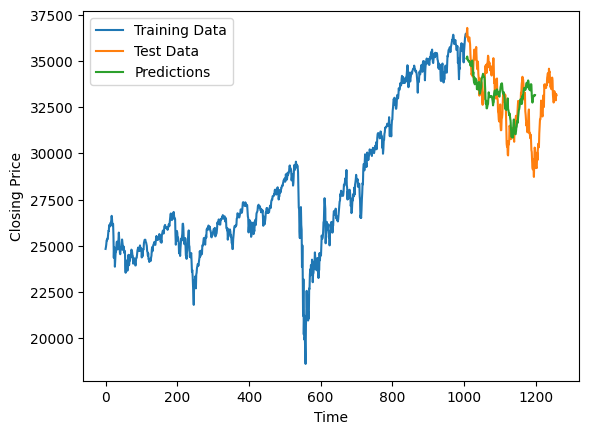

In [125]:
#Get the predictions
predictions = get_predictions(model, X_test, y_test, scaler, close_scaler)

# Evaluate the model
evaluate_model(predictions, y_test)

# Visualize the results
visualize_results(train_data, test_data, predictions, scaler)


## Classification Model

### Writing reproducible functions

This script runs a TCN model to classify whether the stock price value will increase the next day or not.

The script has the following functions:

* `load_data()` loads the data from the file `stock_data.csv`.
* `create_model()` creates a TCN model.
* `train_model()` trains the model.
* `evaluate_model()` evaluates the model.

In [190]:

def create_model():
    """
    Creates a TCN model.

    Returns:
        keras.models.Sequential: The created model.
    """

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(5, 1)))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model



def train_model(model, data, labels,epochs=10):
    """
    Trains the model.

    Args:
        model (keras.models.Sequential): The model to train.
        data (np.ndarray): The training data.
        labels (np.ndarray): The training labels.
    """

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.fit(data, labels, epochs=epochs)

def evaluate_model(model, data, labels):
    """
    Evaluates the model.

    Args:
        model (keras.models.Sequential): The model to evaluate.
        data (np.ndarray): The evaluation data.
        labels (np.ndarray): The evaluation labels.

    Returns:
        float: The accuracy of the model.
    """
    predictions = model.predict(np.array(data).flatten())
    accuracy = np.mean(predictions == labels)
    return accuracy

In [188]:
data = fetch_dow_jones_data()
labels = data['Close'].shift(-1) > data['Close']
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.10/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [191]:
model = create_model()
train_model(model, data, labels,epochs=100)

Epoch 1/100
40/40 [==============================] - 2s 4ms/step - loss: 8.5908 - accuracy: 0.4416
Epoch 2/100
40/40 [==============================] - 0s 3ms/step - loss: 8.1255 - accuracy: 0.4718
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 8.1987 - accuracy: 0.4670
Epoch 4/100
40/40 [==============================] - 0s 4ms/step - loss: 8.4447 - accuracy: 0.4512
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 7.9813 - accuracy: 0.4813
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 8.0786 - accuracy: 0.4750
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 8.3332 - accuracy: 0.4583
Epoch 8/100
40/40 [==============================] - 0s 3ms/step - loss: 7.5784 - accuracy: 0.5075
Epoch 9/100
40/40 [==============================] - 0s 3ms/step - loss: 7.9802 - accuracy: 0.4813
Epoch 10/100
40/40 [==============================] - 0s 3ms/step - loss: 8.0773 - accuracy: 0.4750
Epoch 11/